In [ ]:
## Readme: Run the entire thing in Jupyter with a GPU. Put the pre-trained model in Root directory with this jupyternotebook.

In [1]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Reason for Choosing L2 as Lp:

The L2 paradigm measures the Euclidean distance between two vectors, and for images it can be used to measure the pixel-level difference between two images.

We want the perturbations to be as small as possible while at the same time being able to cause misclassification of the model.The L2 paradigm has its advantages in this regard, as it effectively measures pixel-level variance.


The attacking method is FGSM suggested by the Assignment. Finding the max E to maximize the perturbation.
The principle of FGSM is very simple and easy to understand and implement. Only one gradient calculation and one perturbation operation are required to generate adversarial samples.

Loading pre-trained model

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Loading Pre-trained Model from Ass2
model = CustomCNN().to(device)
model.load_state_dict(torch.load('model_architecture_2.pth', map_location=device))
model.eval()

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

Data Preparation

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

# CIFAR-10 class name
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 99804826.05it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


FGSM

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image




class_images = {}
total_l2_distances = []



In [4]:
## attack based on onthogonal_fgsm

def fgsm_attack(image, epsilon, data_grad):

    random_noise = torch.randn_like(data_grad)


    proj = torch.sum(random_noise * data_grad, dim=(1, 2, 3), keepdim=True) / torch.sum(data_grad * data_grad, dim=(1, 2, 3), keepdim=True)


    orthogonal_noise = random_noise - (proj * data_grad)


    orthogonal_noise = orthogonal_noise / torch.norm(orthogonal_noise, p=2, dim=(1, 2, 3), keepdim=True)


    perturbed_image = image + epsilon * orthogonal_noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


class_images = {}
total_l2_distances = []


Finding the Maximum Epsilon to keep the classification maintaining the same

In [5]:
for images, labels in testloader:
    if labels.item() in class_images:
        continue
    images, labels = images.to(device), labels.to(device)

    # Initializing epsilon
    epsilon = 0.0
    step_epsilon = 0.01
    max_epsilon = 0.3
    last_valid_perturbed_data = images.clone()
    last_valid_epsilon = 0.0
    last_valid_pred = None

    while epsilon <= max_epsilon:
        images.requires_grad = True
        output = model(images)
        original_pred = output.argmax(dim=1, keepdim=True)

        loss = F.cross_entropy(output, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_data = fgsm_attack(images, epsilon, data_grad)

        output_perturbed = model(perturbed_data)
        perturbed_pred = output_perturbed.argmax(dim=1, keepdim=True)

        if original_pred.item() != perturbed_pred.item():
            break

        last_valid_perturbed_data = perturbed_data
        last_valid_epsilon = epsilon
        last_valid_pred = perturbed_pred
        epsilon += step_epsilon

    if last_valid_pred is None:
        last_valid_pred = original_pred

    # l2
    lp_distance = torch.norm((images - last_valid_perturbed_data).view(-1), p=2)
    total_l2_distances.append(lp_distance.item())

    # PR
    perturbation_residue = torch.abs(images - last_valid_perturbed_data)

    # last and max PR
    class_images[labels.item()] = (images, last_valid_perturbed_data, perturbation_residue, lp_distance.item(), original_pred, last_valid_pred)

    if len(class_images) == 10:  # stop
        break

Print Result

Average L2 Distance: 3.52


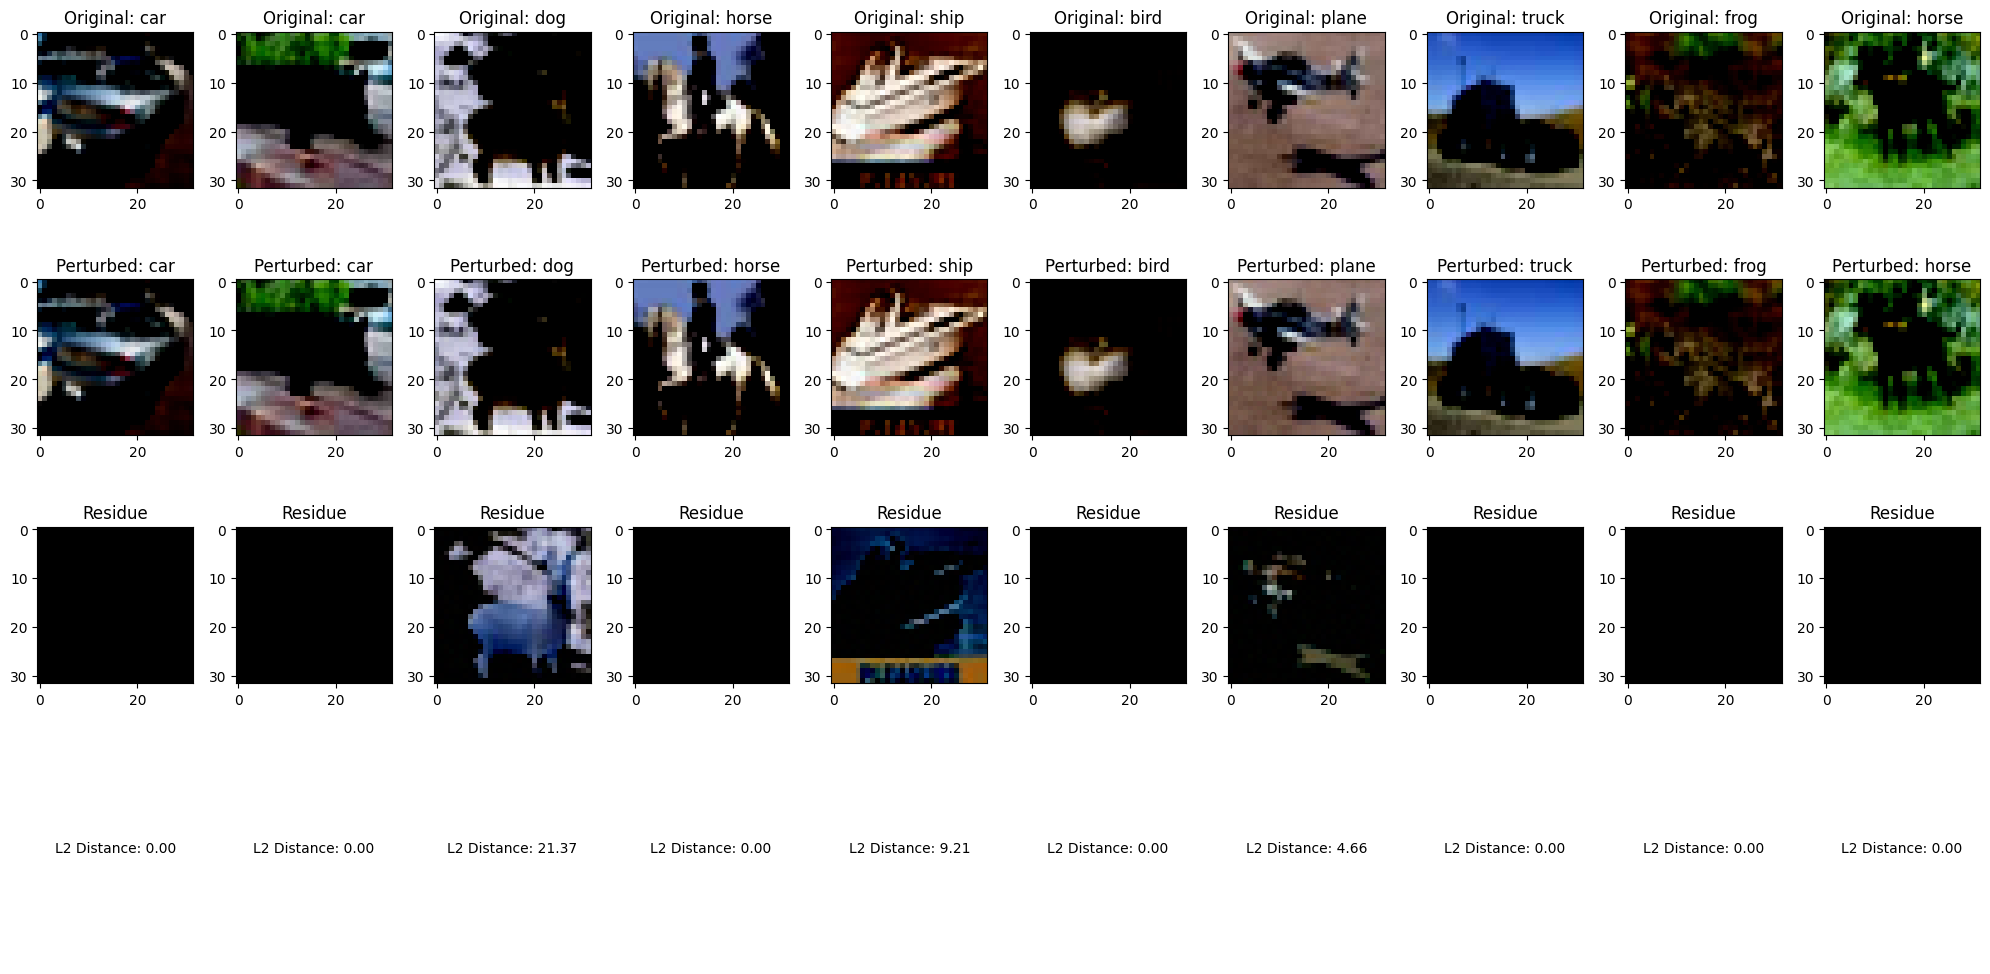

In [6]:
average_l2_distance = sum(total_l2_distances) / len(total_l2_distances)
print(f"Average L2 Distance: {average_l2_distance:.2f}")

# result
fig, axs = plt.subplots(4, 10, figsize=(20, 10))
for i, (orig, pert, residue, dist, orig_pred, pert_pred) in enumerate(class_images.values()):
    axs[0, i].imshow(orig[0].cpu().detach().numpy().transpose(1, 2, 0))
    axs[0, i].set_title(f'Original: {classes[orig_pred.item()]}')
    axs[1, i].imshow(pert[0].cpu().detach().numpy().transpose(1, 2, 0))
    axs[1, i].set_title(f'Perturbed: {classes[pert_pred.item()]}')
    axs[2, i].imshow(residue[0].cpu().detach().numpy().transpose(1, 2, 0))
    axs[2, i].set_title(f'Residue')
    axs[3, i].axis('off')
    axs[3, i].text(0.5, 0.5, f'L2 Distance: {dist:.2f}', horizontalalignment='center')

plt.tight_layout()
plt.show()